# Interactive Plots of Covid-19 in Santa Barbara County

As a resident of Santa Barbara County, I'm interested in keeping tabs on levels of Covid-19 infection in my area. Data are available [from the State](https://data.chhs.ca.gov/) and [county](https://publichealthsbc.org/status-reports/). However, I wasn't happy with the format in which the data were presented so I decided to do some visualizations. I'm most interested in tracking the level of current infections and the level on strain on local medical resources.

Code for these visualizations is available [on GitHub](https://github.com/jkibele/SB_Covid).

In [1]:
import re
import urllib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from io import StringIO

In [2]:
# url = 'https://data.chhs.ca.gov/api/3/action/datastore_search?resource_id=6cd8d424-dfaa-4bdd-9410-a3d656e1176e&limit=50000'  
url = 'https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/resource/926fd08f-cc91-4828-af38-bd45de97f8c3/download/statewide_cases.csv'
csv = urllib.request.urlopen(url).read()
df = pd.read_csv(url)
df.DATE = pd.to_datetime(df.DATE)

In [3]:
url = 'https://data.ca.gov/dataset/529ac907-6ba1-4cb7-9aae-8966fc96aeef/resource/42d33765-20fd-44b8-a978-b083b7542225/download/hospitals_by_county.csv'
hdf = pd.read_csv(url)
hdf['Date'] = pd.to_datetime(hdf.todays_date)

In [4]:
hdf.index = hdf.Date
hdf.index.name = 'Date'

sbdf = hdf.query("county == 'Santa Barbara'").sort_index()
name_map = {
    'hospitalized_covid_confirmed_patients': 'Hospitalized (Confirmed)',
    'icu_covid_confirmed_patients': 'ICU (Confirmed)',
    'hospitalized_suspected_covid_patients': 'Hospitalized (Suspected)',
    'icu_suspected_covid_patients': 'ICU (Suspected)'
}
sbdf.rename(columns=name_map, inplace=True)

sbc = sbdf.copy()
sbc['Hospitalized (Confirmed)'] -= sbc['ICU (Confirmed)']
sbc['Hospitalized (Suspected)'] -= sbc['ICU (Suspected)']
sbc['Date'] = sbc.index

cm = plt.get_cmap('tab20')

def mpl_to_plotly(cmap):
    colors = ((np.array(c) * 255).astype('int') for c in cm.colors)
    pl_colorscale = [f'rgb{tuple(color)}' for color in colors]
    return pl_colorscale

pxtab20 = mpl_to_plotly(cm)

## Data from CA Health and Human Services

These data were downloaded from the [CHHS website](https://data.chhs.ca.gov/). They're downloadable in a consistant format from April onward. I've produced my own visualization that I prefer to the one [available on the CHHS website](https://public.tableau.com/views/COVID-19PublicDashboard/Covid-19Hospitals?:embed=y&:display_count=no&:showVizHome=no). You can also see a [full page version](hospitalized_sb.html).

This plot tracks the number of hospitalized Covid-19 patients in SB County over time, as well as cumulative Covid-19 deaths in SB County. It does not track infected patients who may be recovering at home. Patients designated here as "Confirmed" are those that have tested positive for Covid-19. Those designated as "Suspected" are pending test results. For more information, see the [CHHS website](https://data.chhs.ca.gov/dataset/california-covid-19-hospital-data-and-case-statistics).

In [5]:
cm = plt.get_cmap('tab20')

def mpl_to_plotly(cmap, alpha=1.0):
    colors = ((np.array(c) * 255).astype('int') for c in cmap.colors)
    pl_colorscale = [f'rgba{tuple(color) + (alpha,)}' for color in colors]
    return pl_colorscale

pxtab20 = mpl_to_plotly(cm, 0.5)
pxtab10 = mpl_to_plotly(plt.get_cmap('tab10'), 0.5)

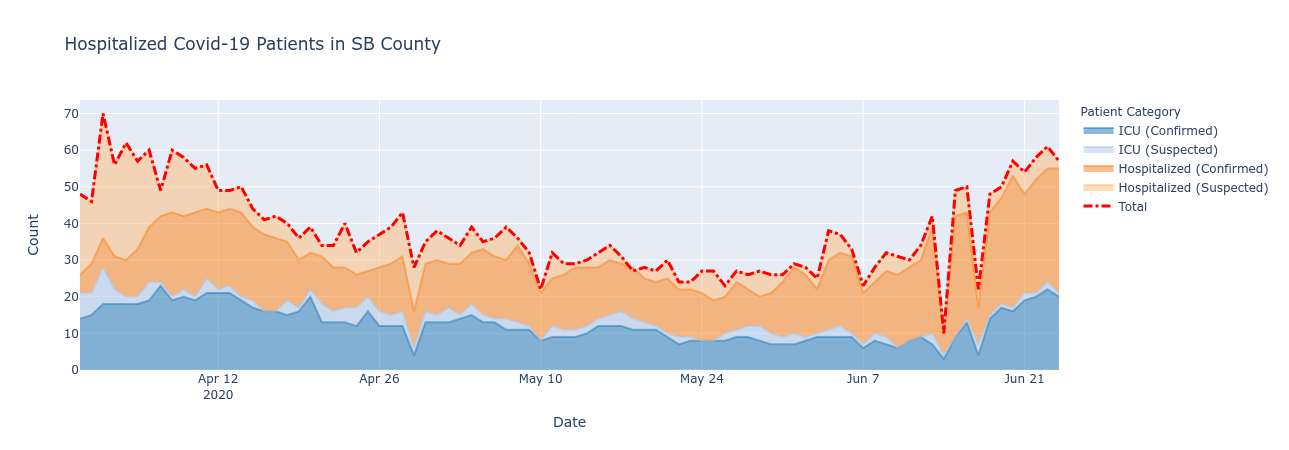

In [6]:
sbcm = sbc.melt(value_vars=name_map.values(), id_vars='Date', var_name='Patient Category', value_name='Count')
pc_order = {
    'ICU (Confirmed)': '1',
    'ICU (Suspected)': '2',
    'Hospitalized (Confirmed)': '3',
    'Hospitalized (Suspected)': '4'
}
sbcm = pd.concat([sbcm.query("`Patient Category`==@cat") for cat in pc_order.keys()])
fig = px.area(sbcm, x='Date', y='Count', color='Patient Category',
              title="Hospitalized Covid-19 Patients in SB County", color_discrete_sequence=pxtab20)
tot = sbcm.groupby('Date').sum()
fig.add_trace(go.Scatter(x=tot.index, y=tot.Count, mode='lines', name='Total', line=dict(dash='dashdot', width=3, color='red')))
# fig.add_trace(go.Scatter(x=sbdf.index, y=sbdf['Total Count Deaths'], mode='lines', name='Cumulative Deaths', 
#                          line=dict(dash='dash', width=2, color='black')))
fig.show()
import plotly.io as pio
pio.write_html(fig, file='hospitalized_sb.html')

In [7]:
# death_per_confirmed = (sbdf['Total Count Deaths'].max() / sbdf['Total Count Confirmed'].max()) * 100
# n_dead = sbdf['Total Count Deaths'].max().astype('int')
# print(f"{n_dead} total deaths. {death_per_confirmed:.2f}% case fatality rate as of {sbdf.index.max().strftime('%B %-d, %Y')}.")

## Data From SB County Public Health Department

[These data](https://publichealthsbc.org/status-reports/) offer a more detailed look at the current status of Covid-19 in SB County. The numbers are broken down by geographic location, including separating the very large number of cases at the [Lompoc Federal Correctional Institution](https://en.wikipedia.org/wiki/Federal_Correctional_Institution,_Lompoc). However, they are not offered for download in any convenient format (at least, not that I've found) and the formatting on the website has not been consistent. I have written a script to scrape data from the site. It works with the format that was adopted on May 13th, so this data set only goes back that far.

Full screen version [here](sb_county_active.html).

In [8]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

url = 'https://publichealthsbc.org/status-reports/'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

page = urlopen(req).read()
soup = BeautifulSoup(page, 'html.parser')

status_containers = soup.findAll('div', class_='elementor-accordion-item')

def getDate(stat_con):
    date_text = stat_con.find('div', class_='elementor-tab-title').text.replace('\n', '').replace('as of ', '')
    return pd.to_datetime(str(date_text))

def getTable(stat_con):
    try:
        tab = stat_con.find('td', text='Active Cases').findParents('table')[0]
    except AttributeError:
        tab = None
    return tab

def getDataframe(stat_con):
    date = getDate(stat_con)
    tab_html = getTable(stat_con)
    df = pd.read_html(str(tab_html), header=0, index_col=0)[0]
    df = df.apply(lambda s: s.replace('—', '0')).apply(pd.to_numeric)
    df['Date'] = date
    df['Category'] = df.index.to_series()
    df.set_index('Date', inplace=True, drop=False)
    return df

def communityDF(stat_con_list):
    df_list = []
    for stat_con in stat_con_list:
        tab = getTable(stat_con)
        if tab:
            df_list.append(getDataframe(stat_con))
    return pd.concat(df_list).pivot(index='Date', columns='Category', values='Community')
        
tables = [getTable(sc) for sc in status_containers]
dfs = [getDataframe(sc) for sc in status_containers[:2]]

def shorten(s):
    pat = re.compile('([A-Z\s]+($|\s))')
    fa = pat.findall(s)
    s = fa[0][0].title() if fa else ''
    return s

def getGeogDF(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
        df['Date'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
    return df

def getDailyCases(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    df_list = []
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
        df['date_label'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
        keep_these = ['Date', 'Daily Cases', 'Geographic Area']
        df_list.append(df[keep_these])
    df = pd.concat(df_list)
    df = pd.pivot(df, index='Date', columns='Geographic Area', values='Daily Cases')
    return df

def getTotalConfirmed(soup):
    status_containers = soup.findAll('div', class_='elementor-accordion-item')
    df_list = []
    for sc in status_containers:
        date = getDate(sc)
        try:
            tab = sc.find('strong', text='Geographic Area').findParents('table')[0]
        except AttributeError:
            continue
        df = pd.read_html(str(tab), header=0)[0]
        df['Date'] = date
#         df['Date'] = df.Date.apply(lambda d: d.date()).apply(lambda d: d.strftime('%b %d'))
        df['Geographic Area'] = df['Geographic Area'].apply(shorten)
        df = df.query("`Geographic Area` != ''")
        keep_these = ['Date', 'Total Confirmed Cases', 'Geographic Area']
        df_list.append(df[keep_these])
    df = pd.concat(df_list)
    df = pd.pivot(df, index='Date', columns='Geographic Area', values='Total Confirmed Cases')
    return df

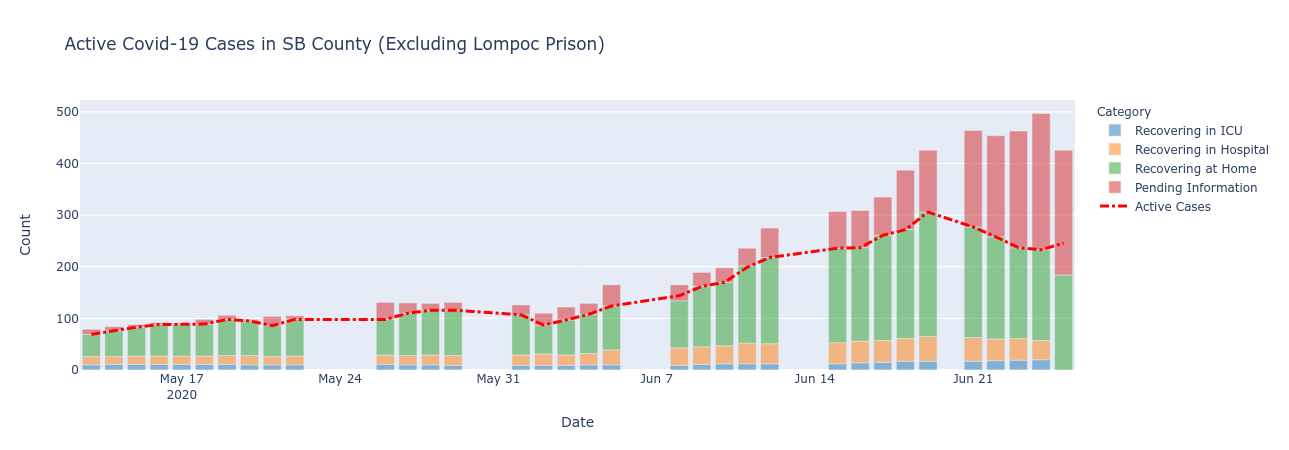

In [9]:
cdf = communityDF(status_containers)
cdf['Date'] = cdf.index.normalize()
cdf = pd.DataFrame(cdf.to_records(index=False)).sort_values('Date')
cdf['Recovering in Hospital'] -= cdf['Recovering in ICU']
plot_cols = ['Pending Information', 'Recovering at Home', 'Recovering in Hospital', 'Recovering in ICU', 'Date']
cdfm = cdf[plot_cols].melt(value_vars=['Pending Information', 'Recovering at Home', 'Recovering in Hospital', 'Recovering in ICU'],
                           id_vars='Date', var_name='Category', value_name='Count')
cat_order = [
    'Recovering in ICU',
    'Recovering in Hospital',
    'Recovering at Home',
    'Pending Information'
]
cdfm = pd.concat([cdfm.query("`Category`==@cat") for cat in cat_order])
cdfm.Category.unique()

fig = px.bar(cdfm, x='Date', y='Count', color='Category', color_discrete_sequence=pxtab10,
            title="Active Covid-19 Cases in SB County (Excluding Lompoc Prison)")
# tot = cdfm.query("Category != 'Pending Information'").groupby('Date').sum()
act_cases = cdf[['Active Cases', 'Date']]
act_cases = act_cases.set_index('Date')
fig.add_trace(go.Scatter(x=act_cases.index, y=act_cases['Active Cases'], mode='lines', name='Active Cases', line=dict(dash='dashdot', width=3, color='red')))
# min_day = cdf.Date.min()
# st_tot = tot.query("index >= @min_day")
# fig.add_trace(go.Scatter(x=st_tot.index, y=st_tot.Count, mode='lines', name='Total Covid Patients According to CHHS', line=dict(dash='dashdot', width=3, color='gray')))
fig.show()
pio.write_html(fig, file='sb_county_active.html')

### Additional Plots from County Data

These are some additional non-interactive plots and one interactive plot based on the SB County data. They explore the geographic break down of Covid-19 cases in SB County. Please note that there are gaps in the x-axis for days where numbers were not reported. On the plot above, these gaps are clearly visible. On the plots below, the gaps in reporting still exist but they are more difficult to see.

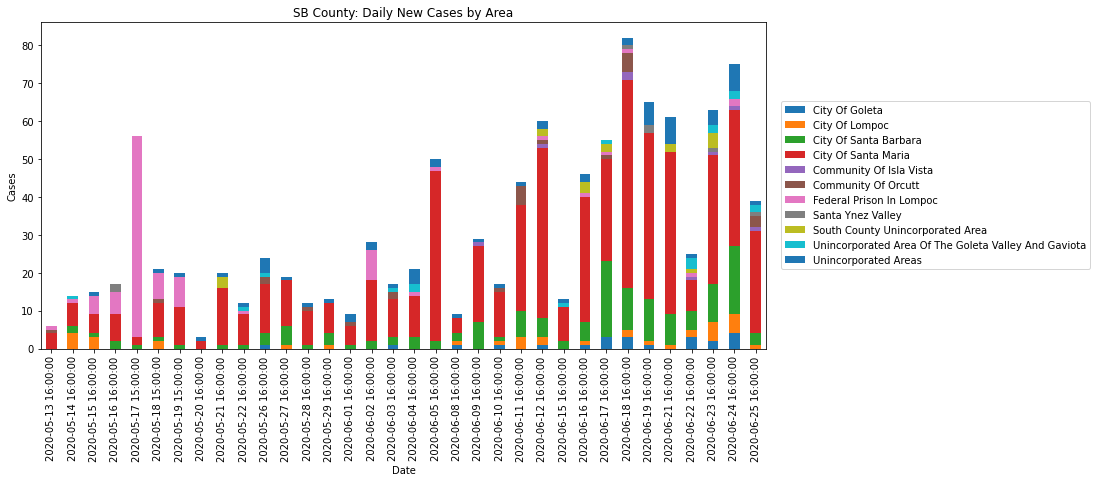

In [10]:
dcdf = getDailyCases(soup).astype('float')
ax = dcdf.plot.bar(stacked=True, figsize=(13, 6), title='SB County: Daily New Cases by Area')
foo = ax.set_ylabel('Cases')
foo = plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

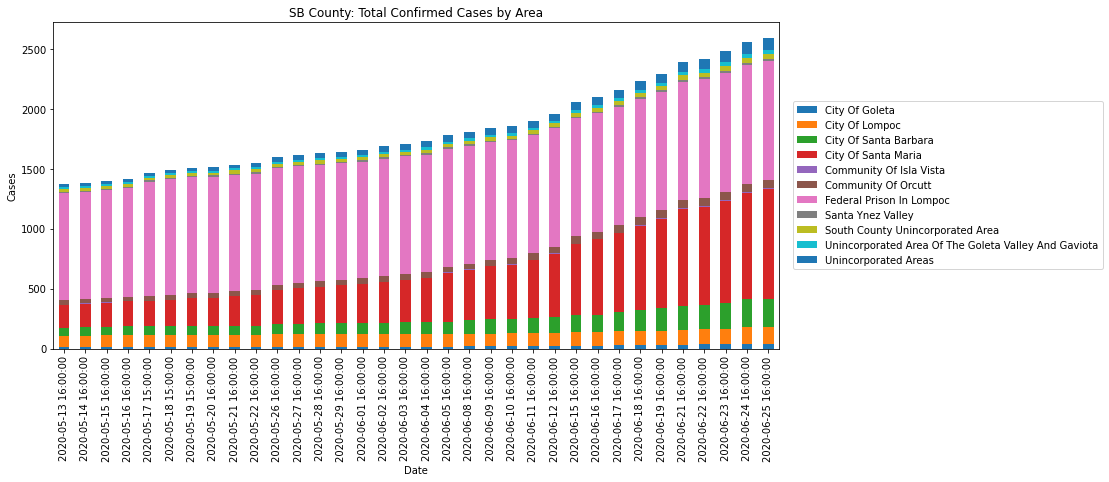

In [11]:
tcdf = getTotalConfirmed(soup).astype('float')
ax = tcdf.plot.bar(stacked=True, figsize=(13, 6), title='SB County: Total Confirmed Cases by Area')
foo = ax.set_ylabel('Cases')
foo = plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

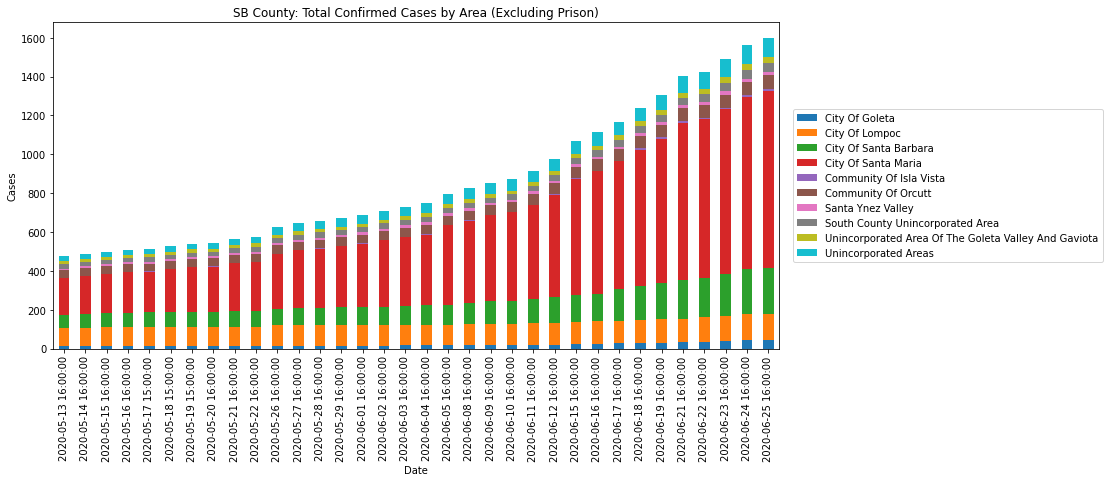

In [12]:
ax = tcdf.drop("Federal Prison In Lompoc", axis=1).plot.bar(stacked=True, figsize=(13, 6), title='SB County: Total Confirmed Cases by Area (Excluding Prison)')
foo = ax.set_ylabel('Cases')
foo = plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)

In [13]:
tclong = tcdf.drop('Federal Prison In Lompoc', axis=1).copy()
tclong.rename(
    {'Unincorporated Area Of The Goleta Valley And Gaviota': 'Unincorporated Goleta/Gaviota'},
    axis='columns', inplace=True
)
tclong.columns = [c.rstrip() for c in tclong.columns]
tclong.index = tclong.index.normalize()
tclong = tclong.reset_index().melt(id_vars='Date', value_name='Count', var_name='Geographic Area')
tclong.Count = tclong.Count.astype('int')
tclong['Day of the Year'] = tclong.Date.apply(lambda d: d.dayofyear)
tclong.sort_values(['Date', 'Geographic Area'], inplace=True)
tclong.to_pickle('tclong.pickle')
# tclong.head()

Full screen facet plot available [here](sb_county_cumulative_facet.html).

In [14]:
def grp_interp(grp):
    grp = grp.reindex(pd.date_range(tclong.Date.min(), tclong.Date.max()))
    grp.Count = grp.Count.interpolate()
    grp['Day of the Year'] = grp['Day of the Year'].interpolate()
    grp.Date = grp.index.to_series()
    grp['Geographic Area'] = grp['Geographic Area'].fillna(method='ffill')
    return grp

changes = {}
for gname, grp in tclong.set_index('Date', drop=False).sort_index().groupby('Geographic Area'):
    idx = grp.index
    ser = grp_interp(grp).Count.pct_change(periods=3) * 100
    changes.update({gname: ser[idx]})
chdf = pd.DataFrame(changes)
chdf = chdf.reset_index().melt(value_name='Change (3 day %)', var_name='Geographic Area', id_vars='Date')
with_change = pd.merge(tclong, chdf, how='left', left_on=['Geographic Area', 'Date'], right_on=['Geographic Area', 'Date'])

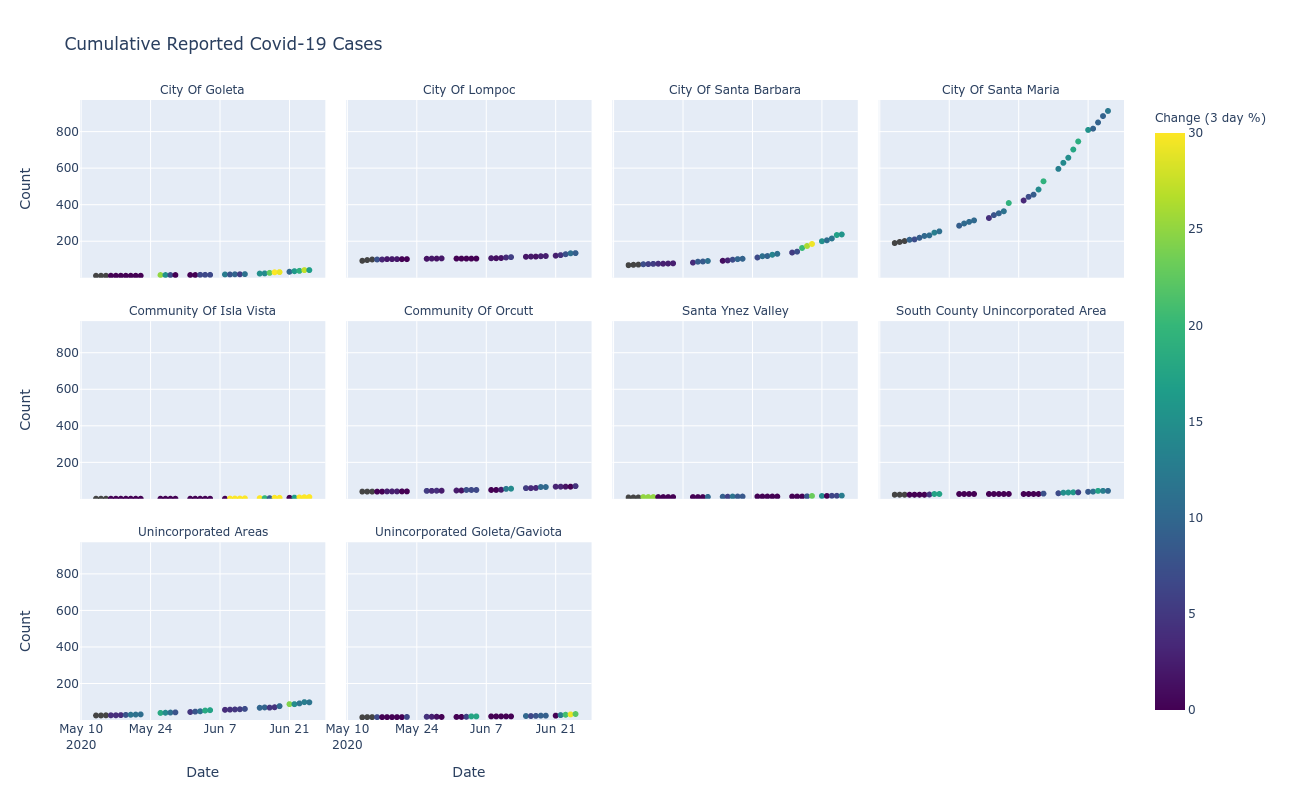

In [15]:
fig = px.scatter(
    with_change, x='Date', y='Count', color='Change (3 day %)',
    range_color=[0, 30], color_continuous_scale=px.colors.sequential.Viridis,
    facet_col='Geographic Area', 
    facet_col_wrap=4, height=800,
#     width=1000,
    title='Cumulative Reported Covid-19 Cases',
#     trendline='ols', log_y=True
)
# fig.update_layout(yaxis_type='log')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_yaxes(matches='y', showticklabels=True)
fig.show()
pio.write_html(fig, file='sb_county_cumulative_facet.html')

Things look kind of nuts in Santa Maria, so I went out on a limb and [made a simple model](SM_model_page.html).

# Caveats!

No one is paying me to do this. I do have a PhD, but it's in Marine Science, so I am in no way qualified to give out public health advice. I'm not trying to. I'm not responsible for the quality of the data. I'm just trying to visualize some one else's data set. ...and I did it as quickly as possible, so I may have even done that wrong. Feel free to take a look at [the code I wrote](https://github.com/jkibele/SB_Covid) and offer helpful suggestions or just tell me I'm dumb and did stuff wrong.

### State Doesn't Match County

It looks like the numbers from the CHHS don't match the numbers from the SB County Public Health Department. I'm not sure what to say about that. It's possible that I've bodged the data wrangling, but I've checked several times and I think my state numbers match the state website, and my county numbers seem match the county website. So, if I didn't mess it up, I'm guessing there may be problems at the state level aggregating all the county data. ...and I don't blame them. There are 58 counties in CA, so the state is probably getting data reported 60 different ways (see "On Data Quality" below). So, basically, I think the county numbers are probably more reliable. But I'm inluding the state numbers because it's a longer time series. There's also been some [local reporting](https://lompocrecord.com/news/local/comparing-state-county-metrics-for-covid-19-a-confusing-exercise/article_6e6f15b7-0fd0-5696-95ed-8c0fe1fed2bd.html) on the discrepancies.

Here's a plot that shows the dicrepancy:

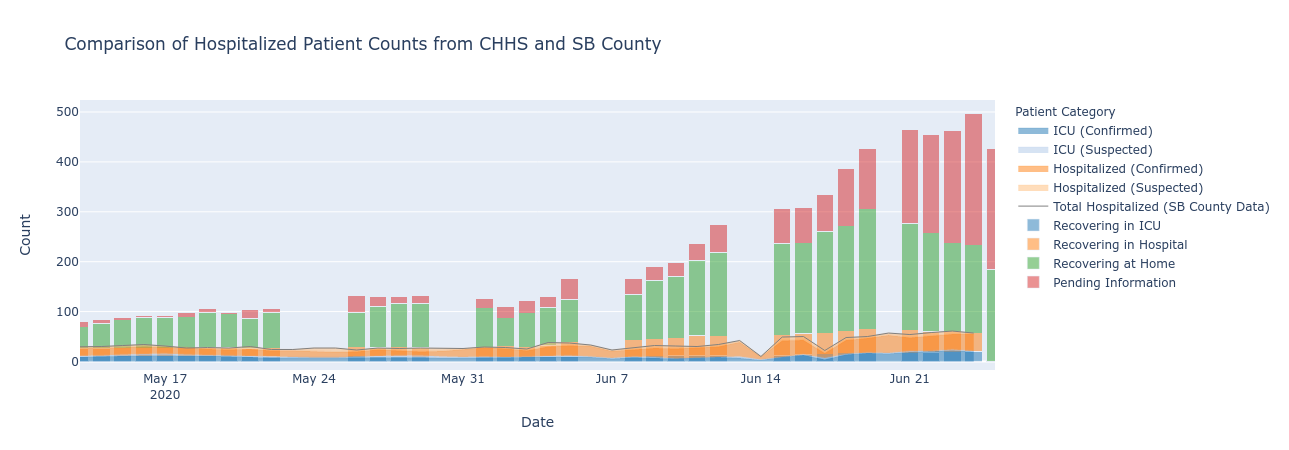

In [16]:
sbcm = sbc.melt(value_vars=name_map.values(), id_vars='Date', var_name='Patient Category', value_name='Count')
pc_order = {
    'ICU (Confirmed)': '1',
    'ICU (Suspected)': '2',
    'Hospitalized (Confirmed)': '3',
    'Hospitalized (Suspected)': '4'
}
sbcm = pd.concat([sbcm.query("`Patient Category`==@cat") for cat in pc_order.keys()])
fig = px.area(sbcm, x='Date', y='Count', color='Patient Category',
              title="Comparison of Hospitalized Patient Counts from CHHS and SB County", color_discrete_sequence=mpl_to_plotly(cm, 0.1))
tot = sbcm.groupby('Date').sum()
fig.add_trace(go.Scatter(x=tot.index, y=tot.Count, mode='lines', name='Total Hospitalized (SB County Data)', line=dict(width=1, color='gray')))
for i, cat in enumerate(cdfm.Category.unique()):
    df = cdfm.query("Category == @cat")
    fig.add_trace(
        go.Bar(
            x=df.Date, 
            y=df.Count, 
            marker_color=pxtab10[i],
            name=cat
        )
    )
fig.update_layout(
    barmode='stack',
    xaxis=dict(
        range=[cdfm.Date.min(), max(cdfm.Date.max(), sbcm.Date.max())]
    )
)

fig.show()

### On Data Quality

I've noticed a few reported numbers that don't quite add up. For instance, the total "Active Cases" don't always equal the sum of "Recovering at Home" and "Recovering in Hospital". It could be that I'm wrong in assuming those should be equal, but it's also possible that they've been reported incorrectly. Either way, let's cut people some slack. I'm sure the people at the county and state levels are doing the best they can. Managing large data sets is never easy. Doing so during a pandemic has got to be even more difficult.

In [18]:
%%capture
!jupyter nbconvert SB_Covid.ipynb --to html --no-input --output index.html
!jupyter nbconvert SantaMariaModel.ipynb --to html --no-input --output SM_model_page.html